# Classifying prompt vs. fake photons from $t\bar{t}$, $t\bar{t}+\gamma$ events

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [3]:
# import tensorflow as tf
from keras.models import save_model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

## Load data

In [4]:
from coffea import hist
from coffea.util import load

In [5]:
outputMC = load('outputMC.coffea')
outputData = load('outputData.coffea')

## Plot Features

In [6]:
np.warnings.filterwarnings('ignore')

In [7]:
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1}

data_legopts = {'labels':[None,'prompt pho','fake pho','data']}

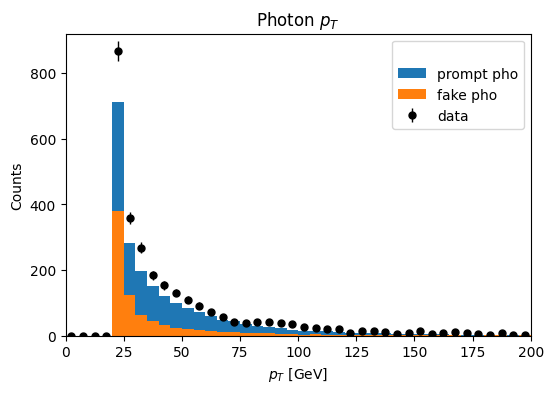

In [8]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_pt_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_pt_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,920); plt.title('Photon $p_T$'); plt.show()

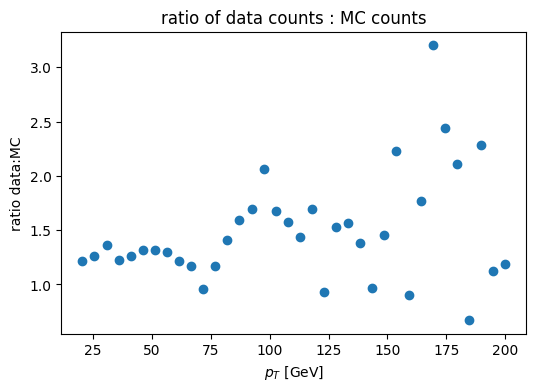

In [9]:
# ratio of data to MC
pt_ratio = (outputData['photon_pt_hist'].values()[()])/(outputMC['photon_pt_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(0,200,pt_ratio.shape[0]),pt_ratio)
plt.xlabel('$p_T$ [GeV]'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

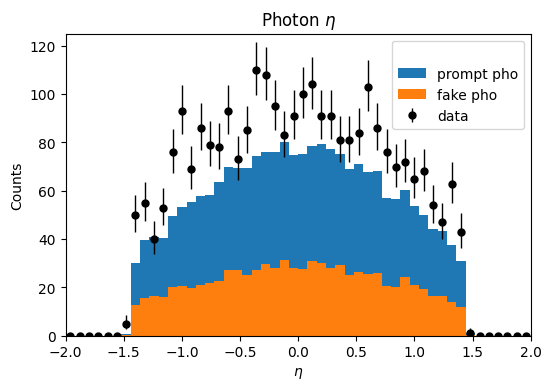

In [10]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_eta_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_eta_hist'],legend_opts=data_legopts,error_opts=data_err_opts)
plt.ylim(0,125); plt.title('Photon $\eta$'); plt.show()

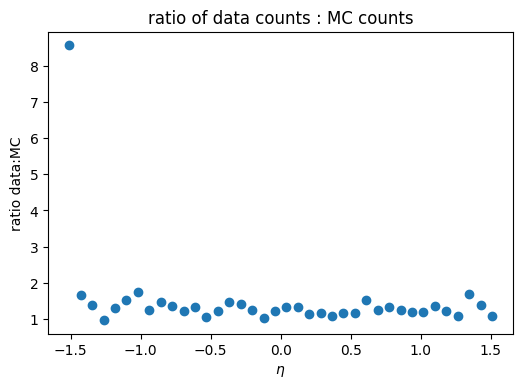

In [11]:
# ratio of data to MC
eta_ratio = (outputData['photon_eta_hist'].values()[()])/(outputMC['photon_eta_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(-2,2,eta_ratio.shape[0]),eta_ratio)
plt.xlabel('$\eta$'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

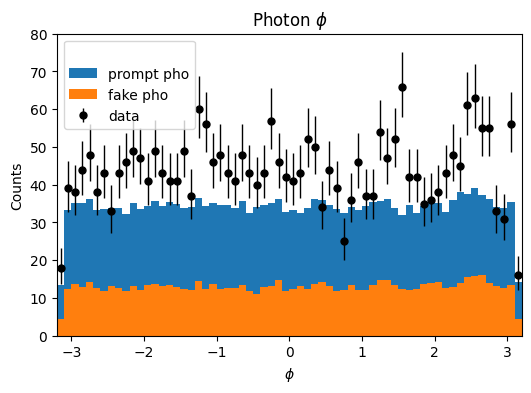

In [12]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_phi_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_phi_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,80); plt.title('Photon $\phi$'); plt.show()

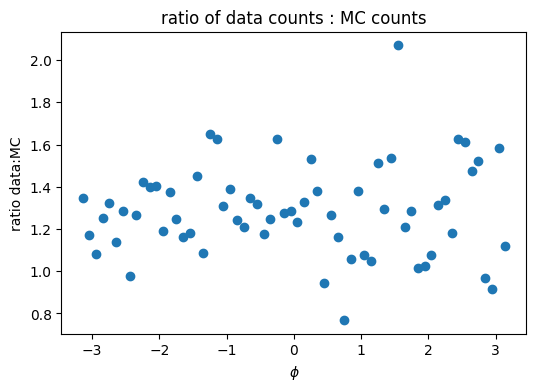

In [13]:
# ratio of data to MC
phi_ratio = (outputData['photon_phi_hist'].values()[()])/(outputMC['photon_phi_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(-np.pi,np.pi,phi_ratio.shape[0]),phi_ratio)
plt.xlabel('$\phi$'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

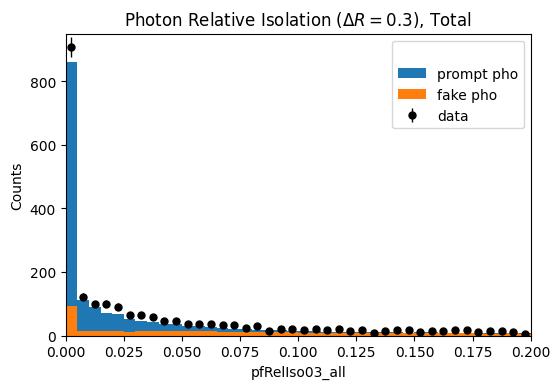

In [14]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_reliso_all_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_reliso_all_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,950); plt.title('Photon Relative Isolation ($\Delta R = 0.3$), Total'); plt.show()

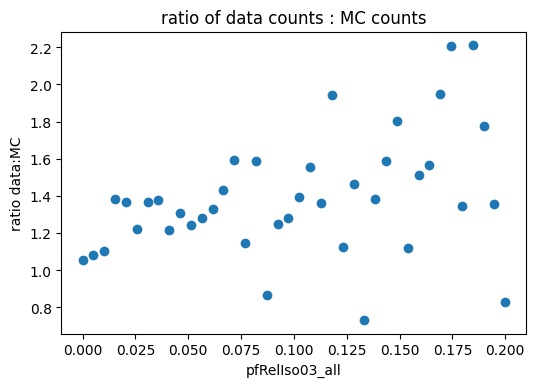

In [15]:
# ratio of data to MC
reliso_all_ratio = (outputData['photon_reliso_all_hist'].values()[()])/(outputMC['photon_reliso_all_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(0,0.2,reliso_all_ratio.shape[0]),reliso_all_ratio)
plt.xlabel('pfRelIso03_all'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

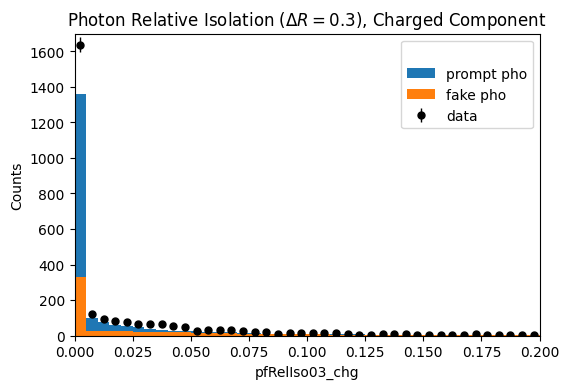

In [16]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_reliso_chg_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_reliso_chg_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,1700); plt.title('Photon Relative Isolation ($\Delta R = 0.3$), Charged Component'); plt.show()

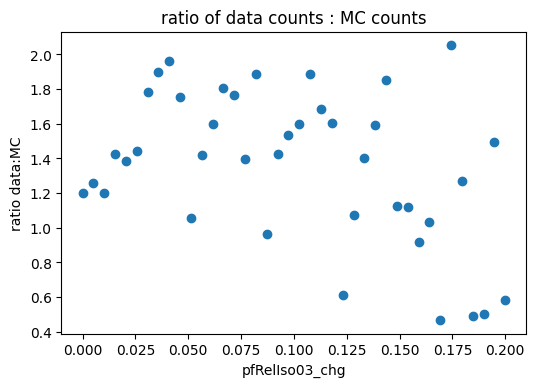

In [17]:
# ratio of data to MC
reliso_chg_ratio = (outputData['photon_reliso_chg_hist'].values()[()])/(outputMC['photon_reliso_chg_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(0,0.2,reliso_chg_ratio.shape[0]),reliso_chg_ratio)
plt.xlabel('pfRelIso03_chg'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

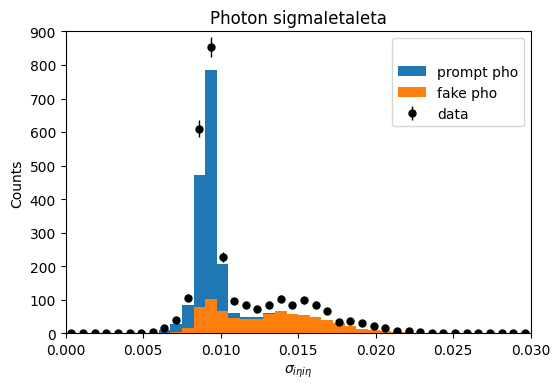

In [18]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_sieie_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts,)
hist.plot1d(outputData['photon_sieie_hist'],legend_opts=data_legopts,error_opts=data_err_opts)
plt.ylim(0,900); plt.title('Photon sigmaIetaIeta'); plt.show()

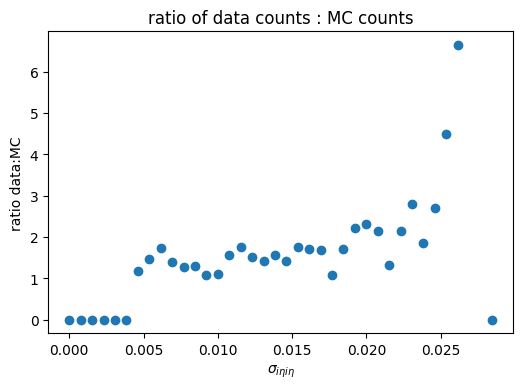

In [19]:
# ratio of data to MC
sieie_ratio = (outputData['photon_sieie_hist'].values()[()])/(outputMC['photon_sieie_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(0,0.03,sieie_ratio.shape[0]),sieie_ratio)
plt.xlabel('$\sigma_{i\eta i\eta}$'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

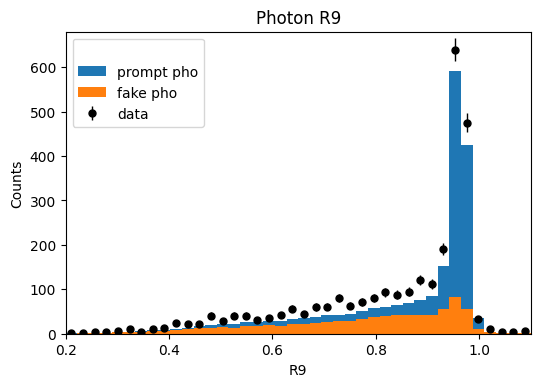

In [20]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_r9_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_r9_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,680); plt.title('Photon R9'); plt.show()

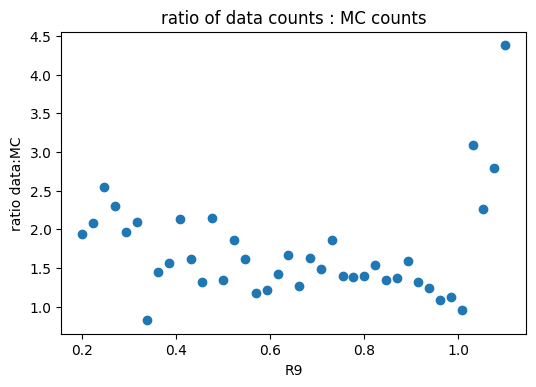

In [21]:
# ratio of data to MC
r9_ratio = (outputData['photon_r9_hist'].values()[()])/(outputMC['photon_r9_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(0.2,1.1,r9_ratio.shape[0]),r9_ratio)
plt.xlabel('R9'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

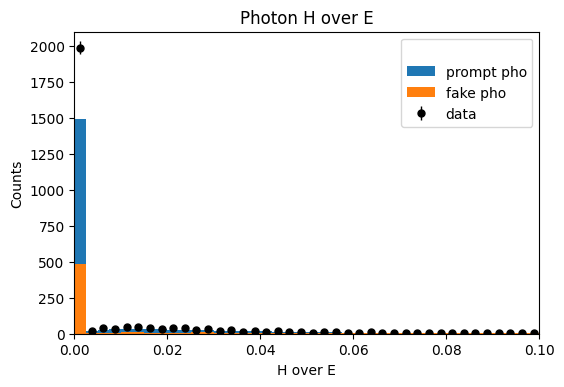

In [22]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_hoe_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['photon_hoe_hist'],legend_opts=data_legopts,error_opts=data_err_opts)
plt.ylim(0,2100); plt.title('Photon H over E'); plt.show()

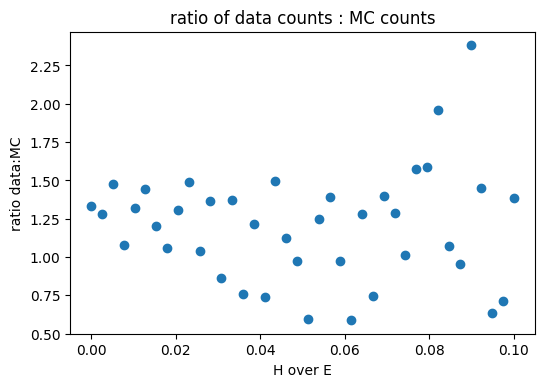

In [23]:
# ratio of data to MC
hoe_ratio = (outputData['photon_hoe_hist'].values()[()])/(outputMC['photon_hoe_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(0,0.1,hoe_ratio.shape[0]),hoe_ratio)
plt.xlabel('H over E'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

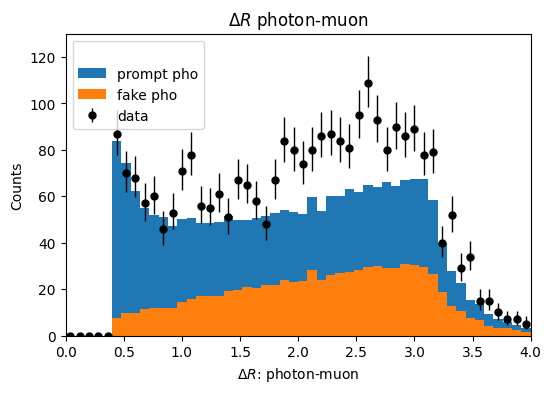

In [24]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['deltaR_photon_lepton_hist'].sum("dataset"),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['deltaR_photon_lepton_hist'],legend_opts=data_legopts,error_opts=data_err_opts)
plt.ylim(0,130); plt.title('$\Delta R$ photon-muon'); plt.show()

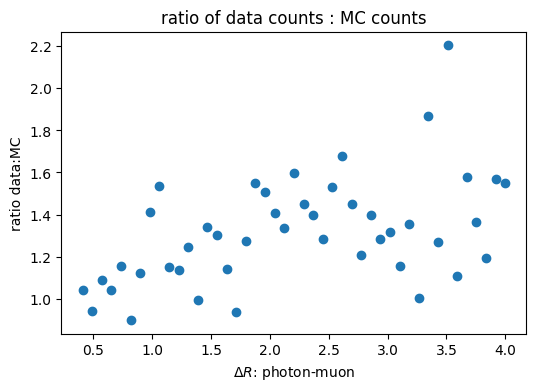

In [25]:
# ratio of data to MC
phoMuDR_ratio = (outputData['deltaR_photon_lepton_hist'].values()[()])/(outputMC['deltaR_photon_lepton_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(0,4,phoMuDR_ratio.shape[0]),phoMuDR_ratio)
plt.xlabel('$\Delta R$: photon-muon'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

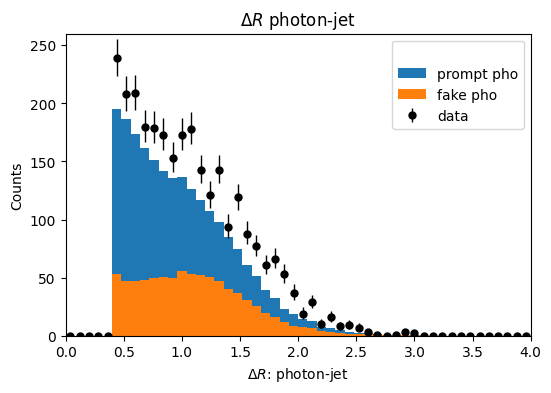

In [26]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['deltaR_photon_jet_hist'].sum('dataset'),overlay="flav",stack=True,legend_opts=data_legopts)
hist.plot1d(outputData['deltaR_photon_jet_hist'],error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,260); plt.title('$\Delta R$ photon-jet'); plt.show()

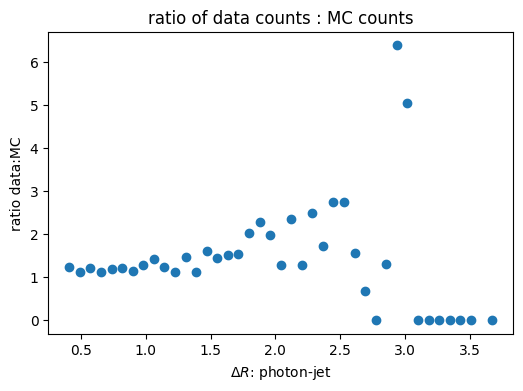

In [27]:
# ratio of data to MC
phoJetDR_ratio = (outputData['deltaR_photon_jet_hist'].values()[()])/(outputMC['deltaR_photon_jet_hist'].sum('dataset').sum('flav').values()[()])

plt.figure(figsize=(6,4),dpi=100)
plt.scatter(np.linspace(0,4,phoJetDR_ratio.shape[0]),phoJetDR_ratio)
plt.xlabel('$\Delta R$: photon-jet'); plt.ylabel('ratio data:MC'); plt.title('ratio of data counts : MC counts')
plt.show()

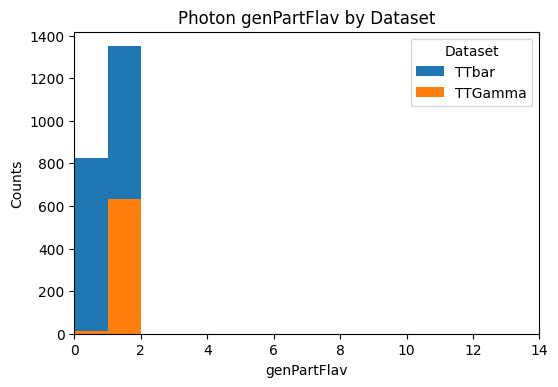

In [28]:
### label ###
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_genPartFlav_hist'],overlay='dataset',stack=True)
plt.title("Photon genPartFlav by Dataset")
plt.show()

In [29]:
outputMC['photon_genPartFlav_hist'].values() # few 13=prompt electrons (last bin)

{('TTbar',): array([8.11051649e+02, 7.19963847e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.44377326e-01]),
 ('TTGamma',): array([1.26630184e+01, 6.30643549e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.67330029e-02])}

## Preprocess data for training

In [30]:
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
    
    # Removed from X_train before training:
    'photon_mvaID': np.array(outputMC['photon_mvaid'].value),
    'file': np.array(outputMC['file'].value),
    
    'photon_genPartFlav': np.array(outputMC['photon_genPartFlav'].value), ## TARGET ##
})

df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_mvaID,file,photon_genPartFlav
count,198772.000000,198772.000000,198772.000000,198772.000000,198772.000000,198772.000000,198772.000000,198772.000000,198772.000000,198772.000000,198772.000000,198772.000000,198772.000000
mean,57.547195,0.007040,0.011438,0.011593,0.895002,0.009564,0.049802,0.014873,1.881211,0.985793,0.675196,0.821031,0.890865
std,56.187378,0.730127,1.813776,0.037378,0.152300,0.001803,0.222227,0.058485,0.925508,0.442431,0.562589,0.383327,0.347519
min,20.000051,-1.444092,-3.141602,0.000000,0.134155,0.000196,0.000000,0.000000,0.400002,0.400008,-0.999512,0.000000,0.000000
25%,25.096556,-0.569458,-1.556152,0.000000,0.885254,0.008865,0.000000,0.000000,1.040229,0.622219,0.731934,1.000000,1.000000
50%,38.354635,0.011695,0.006170,0.000000,0.953613,0.009209,0.003536,0.000000,1.909283,0.900596,0.935547,1.000000,1.000000
75%,65.721701,0.584106,1.584961,0.006378,0.965332,0.009598,0.029855,0.006589,2.672786,1.261417,0.979492,1.000000,1.000000
max,1116.671387,1.444092,3.141602,0.499023,14.968750,0.028076,18.950638,8.643118,4.776289,3.610590,0.998535,1.000000,13.000000


In [31]:
df['photon_genPartFlav'].value_counts()

1     176689
0      22053
13        30
Name: photon_genPartFlav, dtype: int64

In [32]:
# relabel 13 (=prompt electrons) as 0
df['photon_genPartFlav'] = df['photon_genPartFlav'].replace(13,0)
df['photon_genPartFlav'].value_counts()

1    176689
0     22083
Name: photon_genPartFlav, dtype: int64

In [33]:
### shuffle & split into train, val, test datasets ###

X = df.drop(['photon_genPartFlav'],axis=1)
y = df['photon_genPartFlav']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [34]:
### remove MVA ID and file features ###

test_mvaID = X_test['photon_mvaID']

X_train = X_train.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1)
X_test = X_test.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1)
X_val = X_val.drop(['photon_mvaID'],axis=1).drop(['file'],axis=1)

In [35]:
### Scale: mean=0, stdev=1 ###

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

## Build & train model

In [36]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [37]:
callback = EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100, batch_size=512, callbacks=[callback])


Epoch 1/100
233/233 [==============================] - 1s 6ms/step - loss: 0.2748 - accuracy: 0.9027 - val_loss: 0.1379 - val_accuracy: 0.9561
Epoch 2/100
233/233 [==============================] - 1s 4ms/step - loss: 0.1379 - accuracy: 0.9560 - val_loss: 0.1287 - val_accuracy: 0.9584
Epoch 3/100
233/233 [==============================] - 1s 4ms/step - loss: 0.1308 - accuracy: 0.9582 - val_loss: 0.1240 - val_accuracy: 0.9608
Epoch 4/100
233/233 [==============================] - 1s 4ms/step - loss: 0.1272 - accuracy: 0.9591 - val_loss: 0.1218 - val_accuracy: 0.9612
Epoch 5/100
233/233 [==============================] - 1s 4ms/step - loss: 0.1255 - accuracy: 0.9595 - val_loss: 0.1207 - val_accuracy: 0.9612
Epoch 6/100
233/233 [==============================] - 1s 4ms/step - loss: 0.1244 - accuracy: 0.9598 - val_loss: 0.1195 - val_accuracy: 0.9617
Epoch 7/100
233/233 [==============================] - 1s 4ms/step - loss: 0.1237 - accuracy: 0.9601 - val_loss: 0.1191 - val_accuracy: 0.9617

In [38]:
# save model:
path = !pwd
save_model(model, path[0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /udrive/student/abraukman2020/PhotonClassification/assets


## Evaluate & Analyze Model
* Loss and accuracy
* ROC curve, AUC score
* Prediction (output) distribution
* Correlation matrix
* Run model on data


* Compare model predictions to MVA ID score
* Analyze incorrectly classified fake photons (false positive results)

In [39]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.1207
Test accuracy: 0.96094


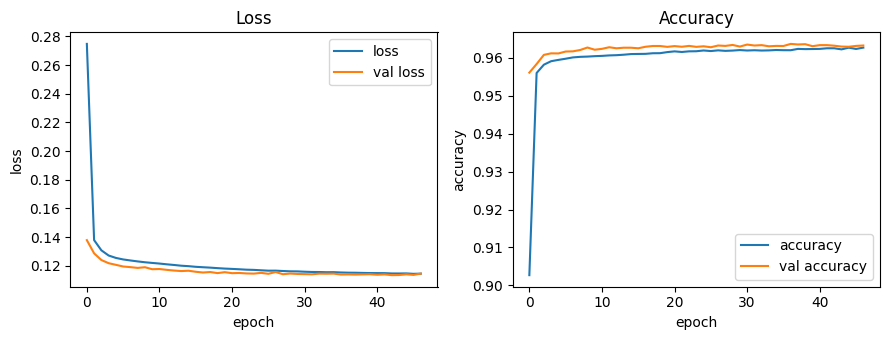

In [40]:
fig, axs = plt.subplots(1,2,figsize=(9,3.5),dpi=100)

axs[0].plot(history.history['loss'],label="loss")
axs[0].plot(history.history['val_loss'],label="val loss")
axs[1].plot(history.history['accuracy'],label="accuracy")
axs[1].plot(history.history['val_accuracy'],label="val accuracy")

axs[0].set_xlabel('epoch'); axs[0].set_ylabel('loss'); axs[0].set_title('Loss')
axs[1].set_xlabel('epoch'); axs[1].set_ylabel('accuracy'); axs[1].set_title('Accuracy')
axs[0].legend(); axs[1].legend()

plt.tight_layout()
plt.show()

### ROC Curve

In [41]:
y_pred = model.predict(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

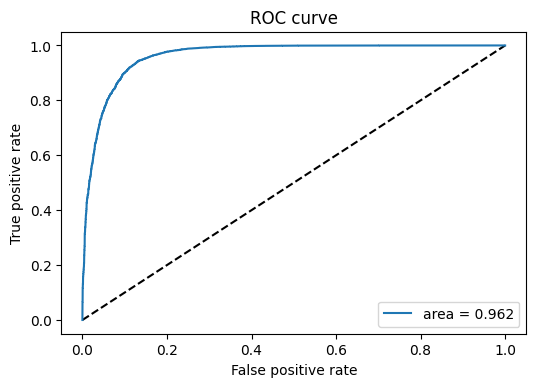

In [42]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Prediction Distribution

In [43]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

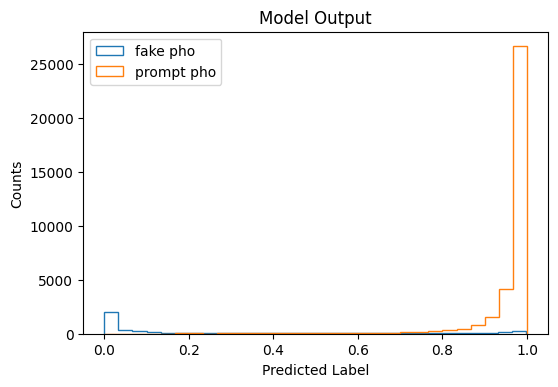

In [44]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(predFalse,bins=30,label='fake pho',histtype='step')
plt.hist(predTrue,bins=30,label='prompt pho',histtype='step')

plt.xlabel('Predicted Label')
plt.ylabel('Counts')
plt.title('Model Output')
plt.legend(loc='upper left')
plt.show()

### Correlation Matrix

In [45]:
X_test['prediction'] = y_pred
X_test.corr()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction
photon_pt,1.000000,0.002462,0.008460,-0.095011,0.116875,-0.101331,-0.078682,-0.101882,0.135457,0.192830,0.132394
photon_eta,0.002462,1.000000,-0.009218,0.000939,0.011958,0.003784,-0.003030,0.002200,-0.007287,-0.003761,0.005881
photon_phi,0.008460,-0.009218,1.000000,-0.000038,-0.003092,0.003116,-0.011208,-0.003777,-0.004736,0.006348,-0.002910
photon_hoe,-0.095011,0.000939,-0.000038,1.000000,-0.130638,0.344911,0.197795,0.240150,0.039055,-0.010510,-0.379175
photon_r9,0.116875,0.011958,-0.003092,-0.130638,1.000000,-0.083117,0.192782,-0.070516,-0.013363,-0.002515,0.269525
photon_sieie,-0.101331,0.003784,0.003116,0.344911,-0.083117,1.000000,0.351794,0.302542,0.071686,0.048878,-0.798592
photon_pfRelIso03_all,-0.078682,-0.003030,-0.011208,0.197795,0.192782,0.351794,1.000000,0.398848,0.065977,-0.011276,-0.412515
photon_pfRelIso03_chg,-0.101882,0.002200,-0.003777,0.240150,-0.070516,0.302542,0.398848,1.000000,0.055860,-0.056828,-0.407000
deltaR_photon_lepton,0.135457,-0.007287,-0.004736,0.039055,-0.013363,0.071686,0.065977,0.055860,1.000000,0.306359,-0.156892
deltaR_photon_jet,0.192830,-0.003761,0.006348,-0.010510,-0.002515,0.048878,-0.011276,-0.056828,0.306359,1.000000,-0.111594


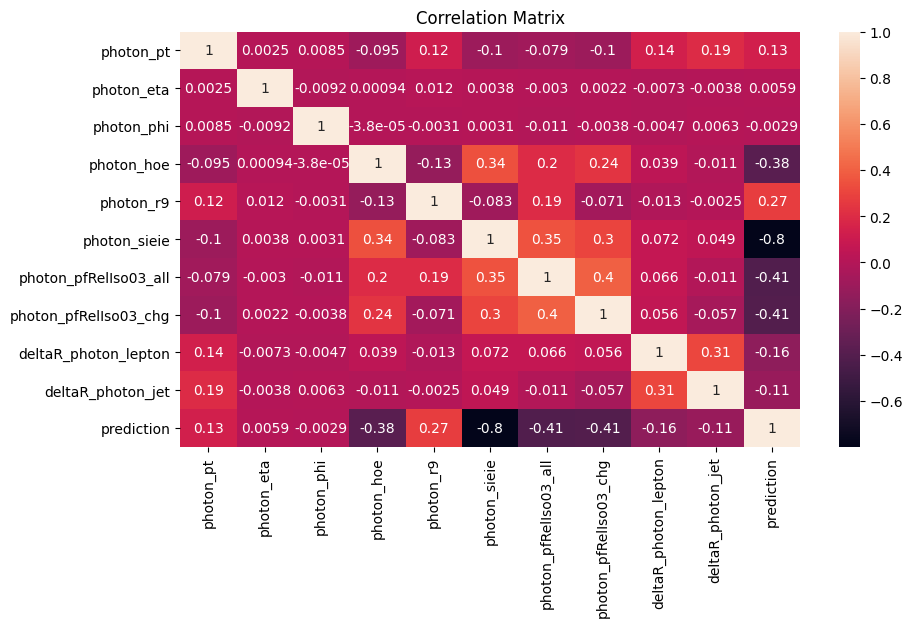

In [46]:
plt.figure(figsize=(10,5.5),dpi=100)
sns.heatmap(X_test.corr(method='pearson'),annot=True)
plt.title('Correlation Matrix')
plt.show()

### Run Model on Data

In [47]:
X_data = pd.DataFrame({
    'photon_pt': np.array(outputData['photon_pt'].value),
    'photon_eta': np.array(outputData['photon_eta'].value),
    'photon_phi': np.array(outputData['photon_phi'].value),
    'photon_hoe': np.array(outputData['photon_hoe'].value),
    'photon_r9': np.array(outputData['photon_r9'].value),
    'photon_sieie': np.array(outputData['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputData['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputData['photon_pfRelIso03_chg'].value),
    
    'deltaR_photon_lepton': np.array(outputData['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputData['deltaR_photon_jet'].value),
})

X_data.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet
count,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000
mean,50.570145,-0.015870,0.039076,0.019639,0.850088,0.011005,0.177118,0.034467,2.034481,1.057087
std,48.258934,0.754341,1.814194,0.056136,0.263620,0.003260,0.442766,0.088914,0.898282,0.476950
min,20.008158,-1.443848,-3.141602,0.000000,0.205566,0.005196,0.000000,0.000000,0.400251,0.400223
25%,23.618339,-0.625336,-1.500305,0.000000,0.744995,0.008942,0.000000,0.000000,1.280361,0.652916
50%,33.360886,-0.023134,0.002344,0.000000,0.917969,0.009453,0.031615,0.000000,2.123417,0.989416
75%,56.436961,0.590912,1.599121,0.010757,0.961914,0.012686,0.166739,0.031940,2.758509,1.361372
max,513.060974,1.443604,3.141113,0.492188,5.441406,0.026840,6.650416,1.445951,4.548167,3.018653


In [48]:
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

In [49]:
y_pred_data = model.predict(X_data_scaled)

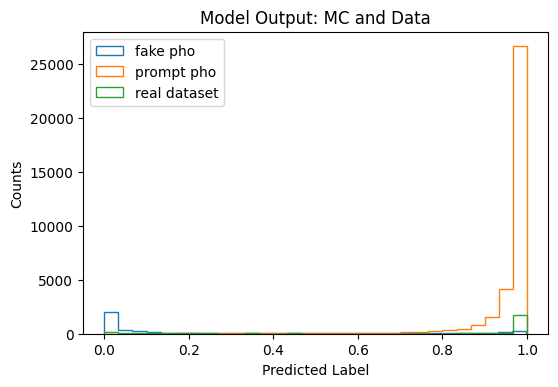

In [50]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(predFalse,bins=30,label='fake pho',histtype='step')
plt.hist(predTrue,bins=30,label='prompt pho',histtype='step')
plt.hist(y_pred_data,bins=30,label="real dataset",histtype='step')

plt.xlabel("Predicted Label")
plt.ylabel("Counts")
plt.title("Model Output: MC and Data")
plt.legend(loc='upper left')

#plt.yscale('log')
plt.show()

### Compare to MVA ID

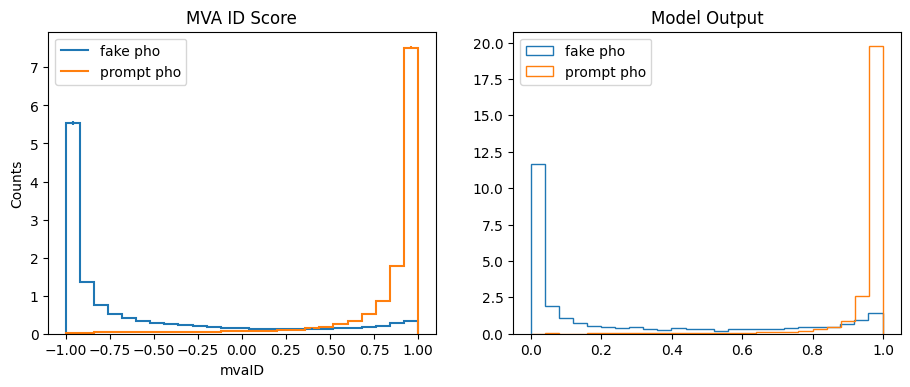

In [51]:
fig, axs = plt.subplots(1,2,figsize=(11,4),dpi=100)

MC_legend_opts = {'loc':'upper left', 'labels': ['fake pho','prompt pho']}
hist.plot1d(outputMC['photon_mvaid_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[0],legend_opts=MC_legend_opts)
axs[0].set_xlim(-1.1,1.1)

axs[1].hist(predFalse,bins=25,density=True,label='fake pho',histtype='step')
axs[1].hist(predTrue,bins=25,density=True,label='prompt pho',histtype='step')
axs[1].legend(loc="upper left")

axs[0].set_title('MVA ID Score')
axs[1].set_title('Model Output')
plt.show()

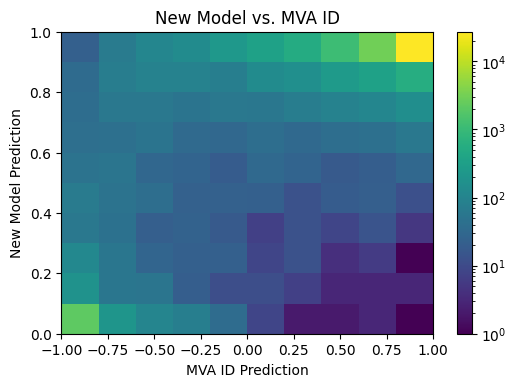

In [52]:
## 2D histograms: new model vs. MVA ID ##
plt.figure(figsize=(6,4),dpi=100)

plt.hist2d(test_mvaID, y_pred.reshape(y_pred.shape[0]),norm=colors.LogNorm())

plt.xlabel('MVA ID Prediction'); plt.xlim(-1,1)
plt.ylabel('New Model Prediction'); plt.ylim(0,1)
plt.title('New Model vs. MVA ID')
plt.colorbar()
plt.show()


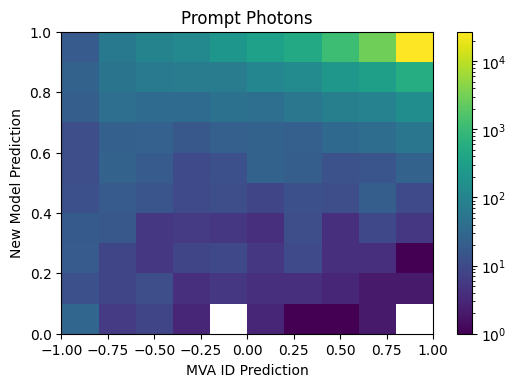

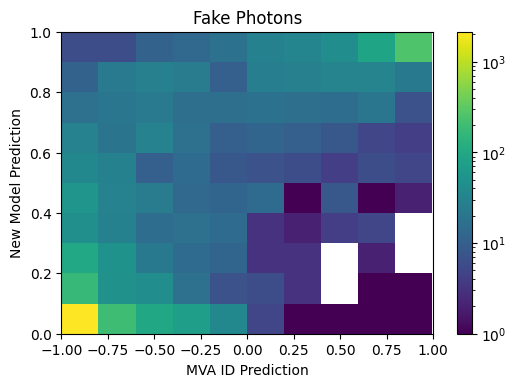

In [53]:
# separate above plot into fake photons and prompt photons

mvaTrue = test_mvaID[y_test==1]
mvaFalse = test_mvaID[y_test==0]

plt.figure(figsize=(6,4),dpi=100)
plt.hist2d(mvaTrue,predTrue.reshape(predTrue.shape[0]),norm=colors.LogNorm())
plt.xlabel('MVA ID Prediction'); plt.ylabel('New Model Prediction')
plt.xlim(-1,1); plt.ylim(0,1)
plt.title('Prompt Photons')
plt.colorbar()
plt.show()

plt.figure(figsize=(6,4),dpi=100)
plt.hist2d(mvaFalse,predFalse.reshape(predFalse.shape[0]),norm=colors.LogNorm())
plt.xlabel('MVA ID Prediction'); plt.ylabel('New Model Prediction')
plt.xlim(-1,1); plt.ylim(0,1)
plt.title('Fake Photons')
plt.colorbar()
plt.show()


In [54]:
### analyze events where model output = 1, MVA ID = -1 ###

X_test['mvaID'] = test_mvaID

modPos_mvaPos = X_test[(X_test['prediction']>0.5) & (X_test['mvaID']>0)]
modNeg_mvaNeg = X_test[(X_test['prediction']<0.5) & (X_test['mvaID']<0)]
modPos_mvaNeg = X_test[(X_test['prediction']>0.5) & (X_test['mvaID']<0)]

modPos_mvaNeg.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction,mvaID
145352,52.178169,1.175537,-1.401367,0.009918,0.610840,0.007351,0.106742,0.028250,0.619570,0.619981,0.956403,-0.790527
14849,28.213514,1.127441,-0.484863,0.035767,0.538574,0.008896,0.070032,0.015201,1.287209,1.283224,0.784511,-0.621094
33891,57.643539,-0.249146,2.150391,0.033447,0.957520,0.009537,2.036617,0.223772,0.652450,0.657519,0.670891,-0.852539
98405,25.562696,0.675903,0.897339,0.000000,0.799316,0.007881,0.161786,0.161786,3.165034,0.423933,0.925942,-0.291748
34577,27.260811,0.523438,3.029297,0.000000,0.439209,0.008888,0.038834,0.037931,2.058221,0.559509,0.934487,-0.614746


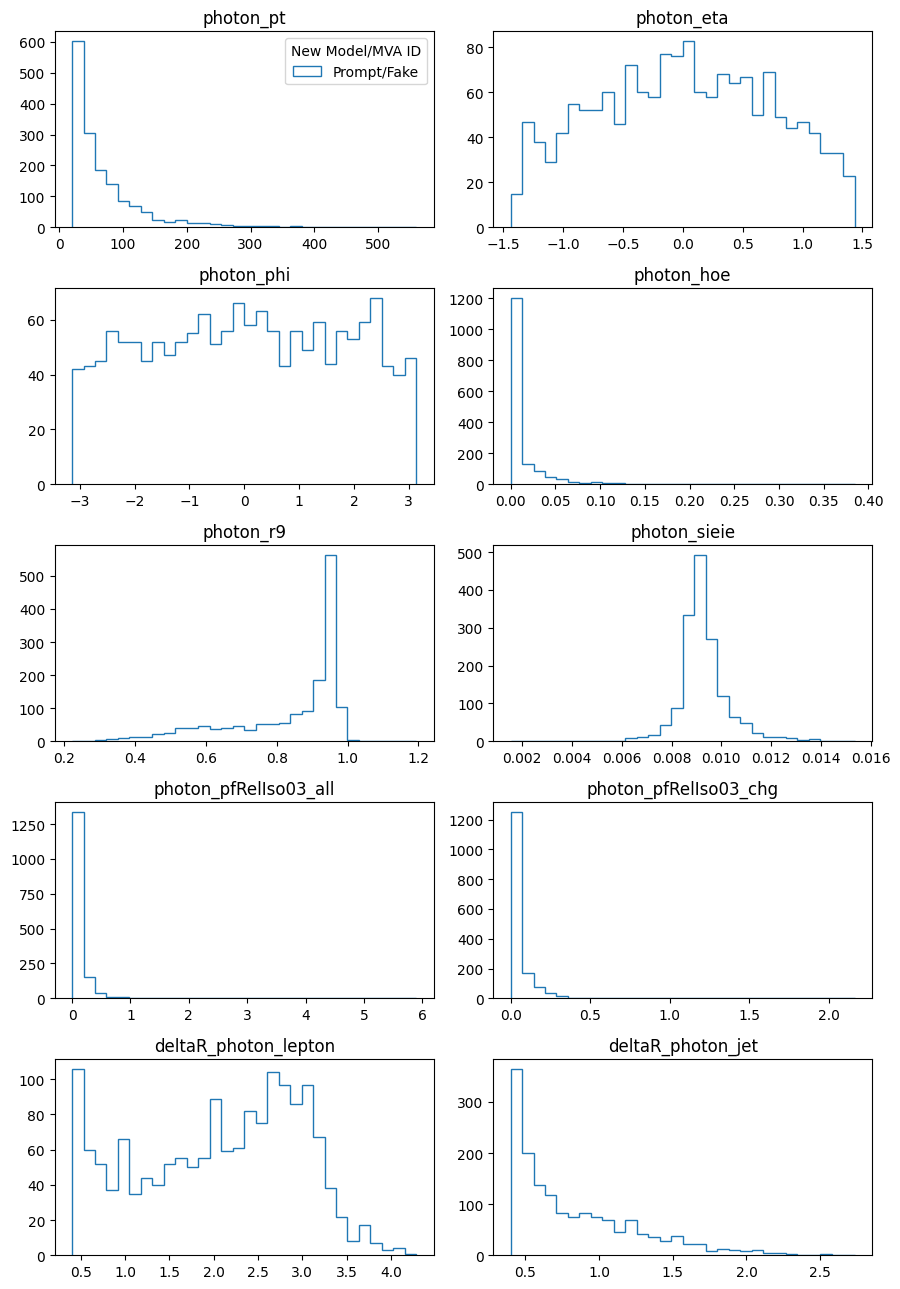

In [55]:
# compare features:
fig, axs = plt.subplots(5,2,figsize=(9,13),dpi=100)

feat = 0
for row in range(5):
    for col in range(2):
        axs[row,col].hist(modPos_mvaNeg[modPos_mvaNeg.keys()[feat]],bins=30,histtype="step",label="Prompt/Fake")
        #axs[row,col].hist(modPos_mvaPos[modPos_mvaNeg.keys()[feat]],bins=30,histtype="step",alpha=0.3,density=True,color="green",label="Prompt/Prompt")
        #axs[row,col].hist(modNeg_mvaNeg[modPos_mvaNeg.keys()[feat]],bins=30,histtype="step",alpha=0.3,density=True,color="red",label="Fake/Fake")
        axs[row,col].set_title(modPos_mvaNeg.keys()[feat])
        feat = feat+1

axs[0,0].legend(loc="best",title="New Model/MVA ID")
fig.tight_layout()
plt.show()

In [56]:
## ROC curve for MVA ID ##

fprMVA, tprMVA, threshMVA = roc_curve(y_test,test_mvaID)
aucMVA = auc(fprMVA,tprMVA)

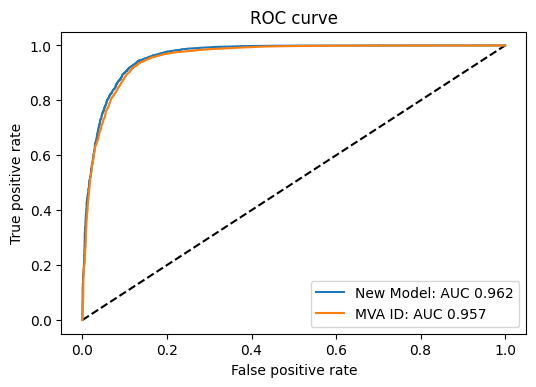

In [57]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='New Model: AUC {:.3f}'.format(area_under_curve))
plt.plot(fprMVA, tprMVA, label='MVA ID: AUC {:.3f}'.format(aucMVA))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Analyze Incorrectly-Classified Fake Photons

In [58]:
X_test['target'] = y_test
X_test.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction,mvaID,target
9417,23.313951,-1.141357,-0.302795,0.047974,6.121094,0.017639,8.522288,0.645364,2.706024,0.934862,1.301278e-24,-0.961914,0
149510,23.708284,-0.066971,-0.886841,0.070068,0.993164,0.009598,0.047422,0.000000,1.619340,0.409398,9.917107e-01,0.983887,1
106157,24.420326,0.718262,-2.104492,0.000000,0.628906,0.008804,0.020186,0.020186,0.732497,0.727155,9.729905e-01,0.914551,1
59909,25.397182,-1.099609,-2.501465,0.000000,0.950684,0.009087,0.000000,0.000000,1.976085,1.980757,9.822410e-01,0.986328,1
3138,31.403984,1.164062,-2.806641,0.000000,0.970215,0.009445,0.000000,0.000000,2.122999,1.567606,9.794276e-01,0.990234,1


In [59]:
# incorrectly-classified fake photons:
# target = 0, prediction > 0.5

falseNeg = X_test[(X_test['target'] == 1) & (X_test['prediction'] < 0.5)]
truePos  = X_test[(X_test['target'] == 1) & (X_test['prediction'] > 0.5)]
trueNeg  = X_test[(X_test['target'] == 0) & (X_test['prediction'] < 0.5)]
falsePos = X_test[(X_test['target'] == 0) & (X_test['prediction'] > 0.5)]

In [60]:
# confusion matrix
con_mat = np.array([len(trueNeg),len(falsePos),len(falseNeg),len(truePos)])
con_mat_names = np.array(['True Neg:','False Pos:','False Neg:','True Pos:'])
con_mat_perc = ((con_mat/np.sum(con_mat))*100).round(2)

con_mat.reshape(2,2)

array([[ 3339,  1166],
       [  387, 34863]])

In [61]:
labels = [f"{v1}\n{v2}\n({v3}%)" for v1,v2,v3 in zip(con_mat_names,con_mat,con_mat_perc)]
labels = np.asarray(labels).reshape(2,2)

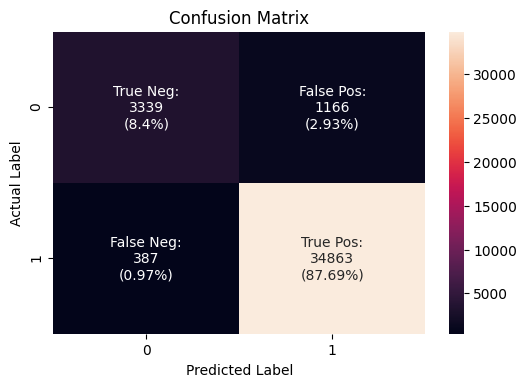

In [62]:
plt.figure(figsize=(6,4),dpi=100)
sns.heatmap(con_mat.reshape(2,2),annot=labels,fmt='')
plt.xlabel('Predicted Label'); plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

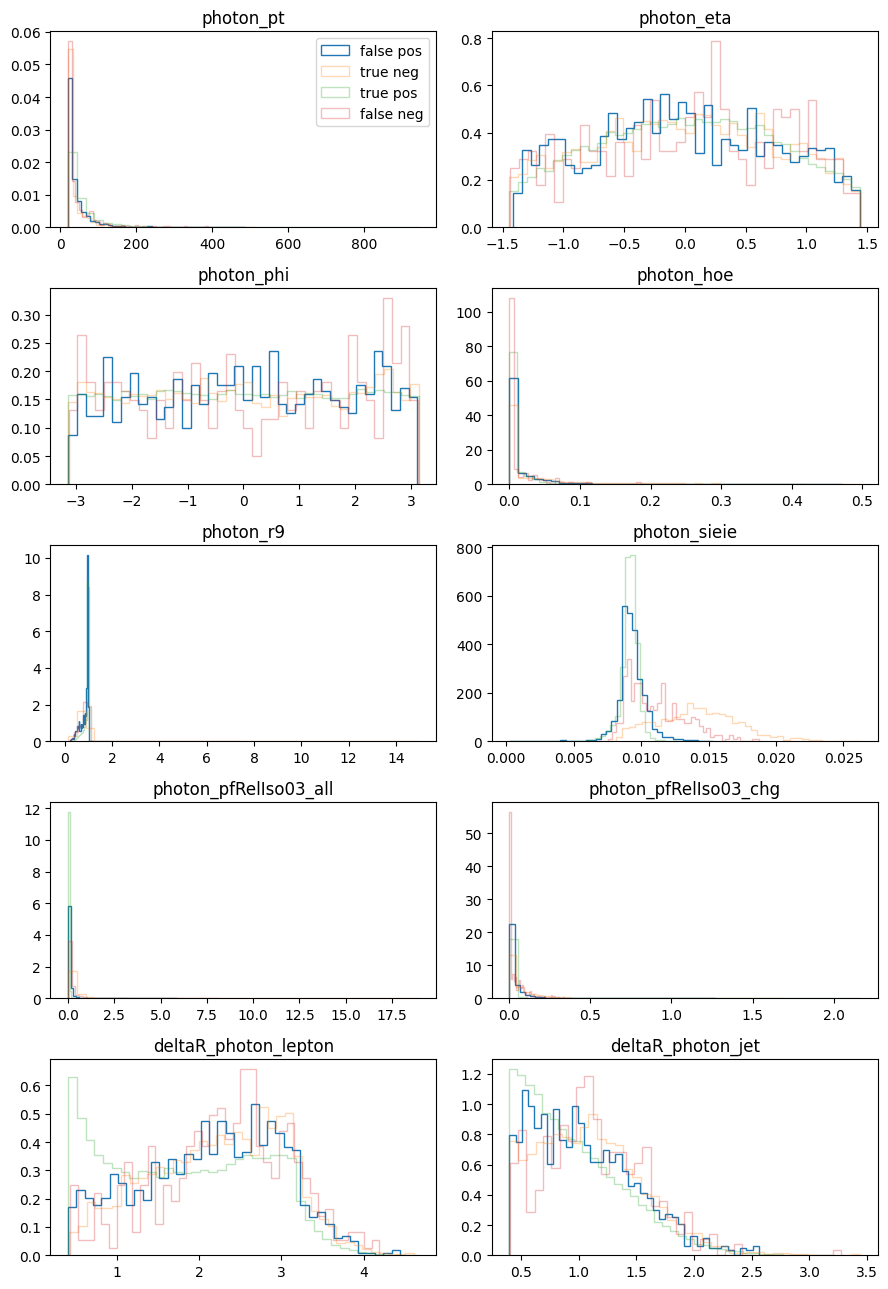

In [63]:
### compare features ###

fig, axs = plt.subplots(5,2,figsize=(9,13),dpi=100)

feat = 0
for row in range(5):
    for col in range(2):
        axs[row,col].hist(falsePos[falsePos.keys()[feat]],bins=40,histtype="step",density=True,label="false pos")
        axs[row,col].hist(trueNeg[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.3,density=True,label="true neg")
        axs[row,col].hist(truePos[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.3,density=True,label="true pos")
        axs[row,col].hist(falseNeg[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.3,density=True,label="false neg")
        
        axs[0,0].legend(loc="best")
        axs[row,col].set_title(falsePos.keys()[feat])
        feat = feat+1

fig.tight_layout()
plt.show()

# falsePos = incorrectly classified fake photons
# trueNeg = correctly classified fake photons (expected to look different from falsePos)
# truePos = correctly classified prompt photons (expected to look like falsePos)

### Plot ROC curve manually

In [64]:
FPR = []
TPR = []

thresholds = np.linspace(0,1,num=201)

# number of positive (P) and negative (N) samples
P = X_test.target.sum()
N = len(X_test.target) - P

# determine number of true pos & false pos samples for each threshold
for thresh in thresholds:
    FP = 0
    TP = 0
    
    pos = X_test[X_test.prediction>=thresh]
    
    TP = pos.target.sum()
    FP = len(pos.target) - TP
    
    FPR.append(FP/N)
    TPR.append(TP/P)

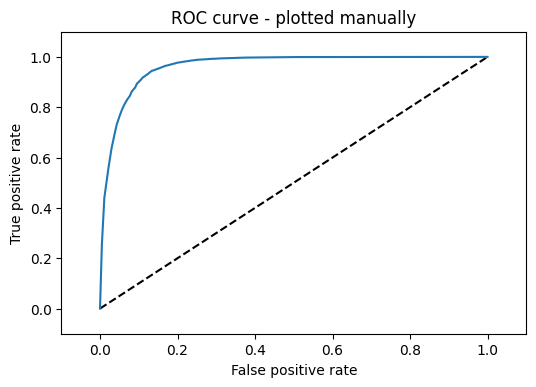

In [65]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(FPR, TPR)

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - plotted manually')
plt.show()